In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/8bcbb4fb-c733-4fc7-92d2-6e4a442e592e___FREC_Scab 3506.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/2bc018ba-3c49-4cf4-9411-a93b7b196f45___FREC_Scab 3326.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/f18c0441-917e-4f34-b26e-a1a71d0adec2___FREC_Scab 3429.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/bc7769cc-805e-42ef-bbcf-0c134ff03276___FREC_Scab 2909.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/48dcb319-8b65-4bac-bba4-aa8ffa8abdd0___FREC_Scab 3519.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/45e34a1f-1d46-42e8-921d-c82f2c9e7cd1___FREC_Scab 3228.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/ff99efdc-a9f8-4360-9c64-f8274f456be5___FREC_Scab 3161.JPG
/kaggle/input/plantvillageapplecolor/Apple___Apple_scab/24d43ad3-24e6-4236-8ef7-59b26852

In [88]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [89]:
dataset_dir = '/kaggle/input/plantvillageapplecolor'

In [90]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=(224, 224), 
    label_mode='int',       
    batch_size=32,         
    shuffle=True            
)

Found 3171 files belonging to 4 classes.


In [91]:
labels = data.class_names
print("Classes:", labels)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [92]:
dataset_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * dataset_size) 
val_size = int(0.15 * dataset_size)   
test_size = int(0.15 * dataset_size)  

In [93]:
train_data = data.take(train_size)
remaining_data = data.skip(train_size)
val_data = remaining_data.take(val_size)
test_data = remaining_data.skip(val_size)

In [102]:
print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [95]:
def count_samples(dataset):
    count = 0
    for images, labels in dataset:
        count += images.shape[0]
    return count

train_count = count_samples(train_data)
val_count = count_samples(val_data)
test_count = count_samples(test_data)

print(f"Nombre d'échantillons dans l'ensemble d'entraînement: {train_count}")
print(f"Nombre d'échantillons dans l'ensemble de validation: {val_count}")
print(f"Nombre d'échantillons dans l'ensemble de test: {test_count}")


Nombre d'échantillons dans l'ensemble d'entraînement: 2240
Nombre d'échantillons dans l'ensemble de validation: 480
Nombre d'échantillons dans l'ensemble de test: 451


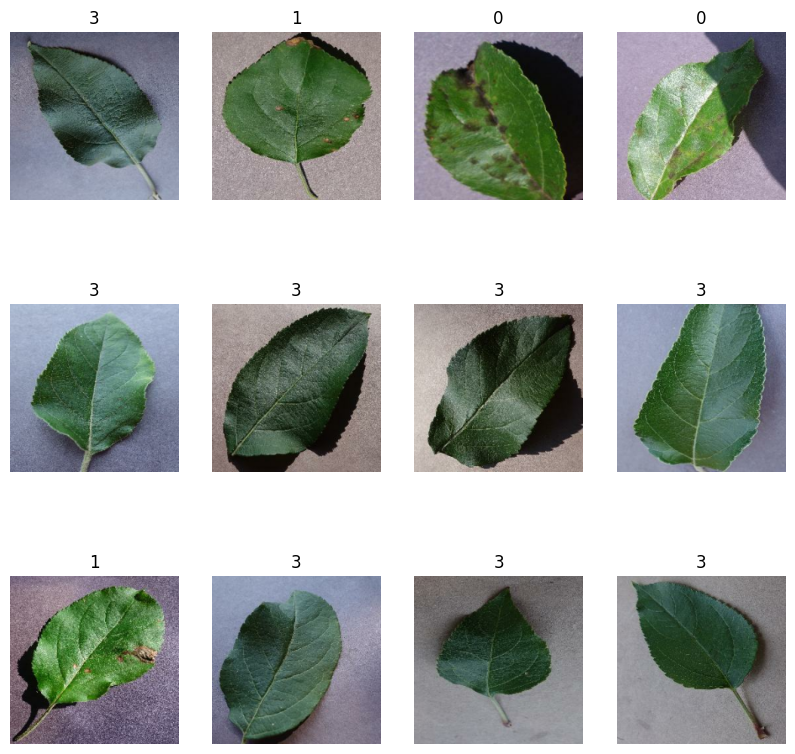

In [97]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1): 
    for i in range(12):  
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.show()

In [98]:
def preprocess_image(image, label):
    image = image / 255.0  
    return image, label

In [99]:
train_data = train_data.map(preprocess_image)
test_data = test_data.map(preprocess_image)
val_data = val_data.map(preprocess_image)

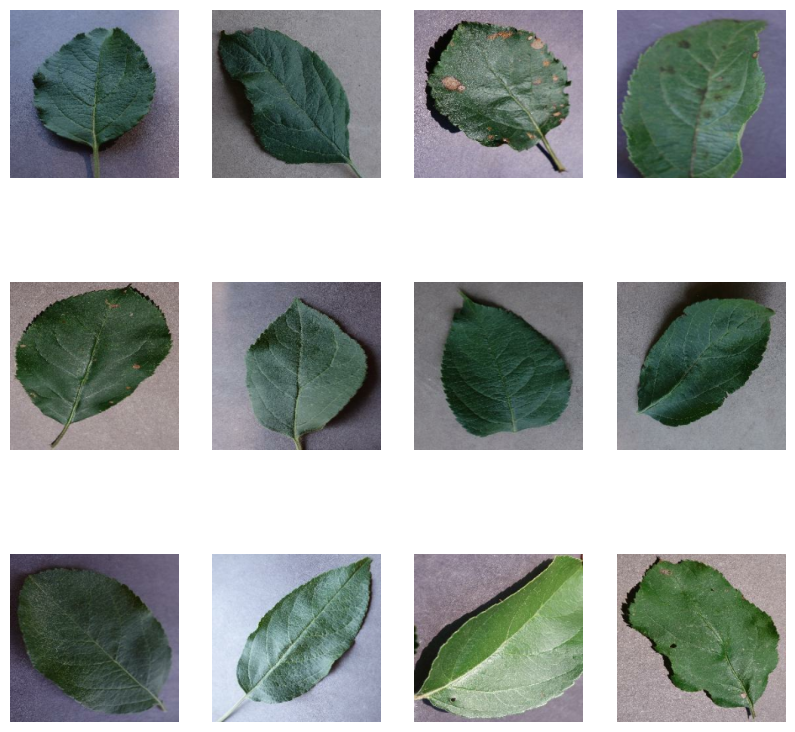

In [100]:
import matplotlib.pyplot as plt

# Fonction pour afficher des échantillons
def display_sample(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(12):  # Montrer 12 échantillons
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")

# Affichage des échantillons de l'ensemble d'entraînement
display_sample(train_data)


In [101]:
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)


In [103]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [104]:
num_classes = 4

In [105]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [106]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [108]:
epochs = 10
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs 
)

Epoch 1/10


I0000 00:00:1729709462.040605     309 service.cc:145] XLA service 0x7afdc0002000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729709462.040688     309 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729709462.040699     309 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/70 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1172 - loss: 1.3890  

I0000 00:00:1729709482.285164     309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.4657 - loss: 1.2653 - val_accuracy: 0.5250 - val_loss: 1.1864
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5044 - loss: 1.2102 - val_accuracy: 0.5292 - val_loss: 1.1806
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5024 - loss: 1.2108 - val_accuracy: 0.5104 - val_loss: 1.1882
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4963 - loss: 1.2136 - val_accuracy: 0.5125 - val_loss: 1.1909
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5029 - loss: 1.2108 - val_accuracy: 0.5292 - val_loss: 1.1750
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5016 - loss: 1.2137 - val_accuracy: 0.5562 - val_loss: 1.1515
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4987 - loss: 1.2220 - val_accuracy: 0.5188 - val_loss: 1.1856
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5043 - loss: 1.2081 - val_accuracy: 0.5396 - val_loss: 

In [109]:
base_model.trainable = True

In [110]:
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [112]:
fine_tune_epochs = 20
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=fine_tune_epochs 
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9857 - loss: 0.0867 - val_accuracy: 0.9229 - val_loss: 0.3398
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9936 - loss: 0.0672 - val_accuracy: 0.9812 - val_loss: 0.1494
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9954 - loss: 0.0543 - val_accuracy: 0.9875 - val_loss: 0.0838
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9921 - loss: 0.0535 - val_accuracy: 0.9896 - val_loss: 0.0577
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9923 - loss: 0.0480 - val_accuracy: 0.9917 - val_loss: 0.0418
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9972 - loss: 0.0345 - val_accuracy: 0.9979 - val_loss: 0.0261
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9977 - loss: 0.0347 - val_accuracy: 0.9958 - val_loss: 0.0298
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9978 - loss: 0.0284 - val_accu

In [113]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy:.2f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.9947 - loss: 0.0191
Test accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


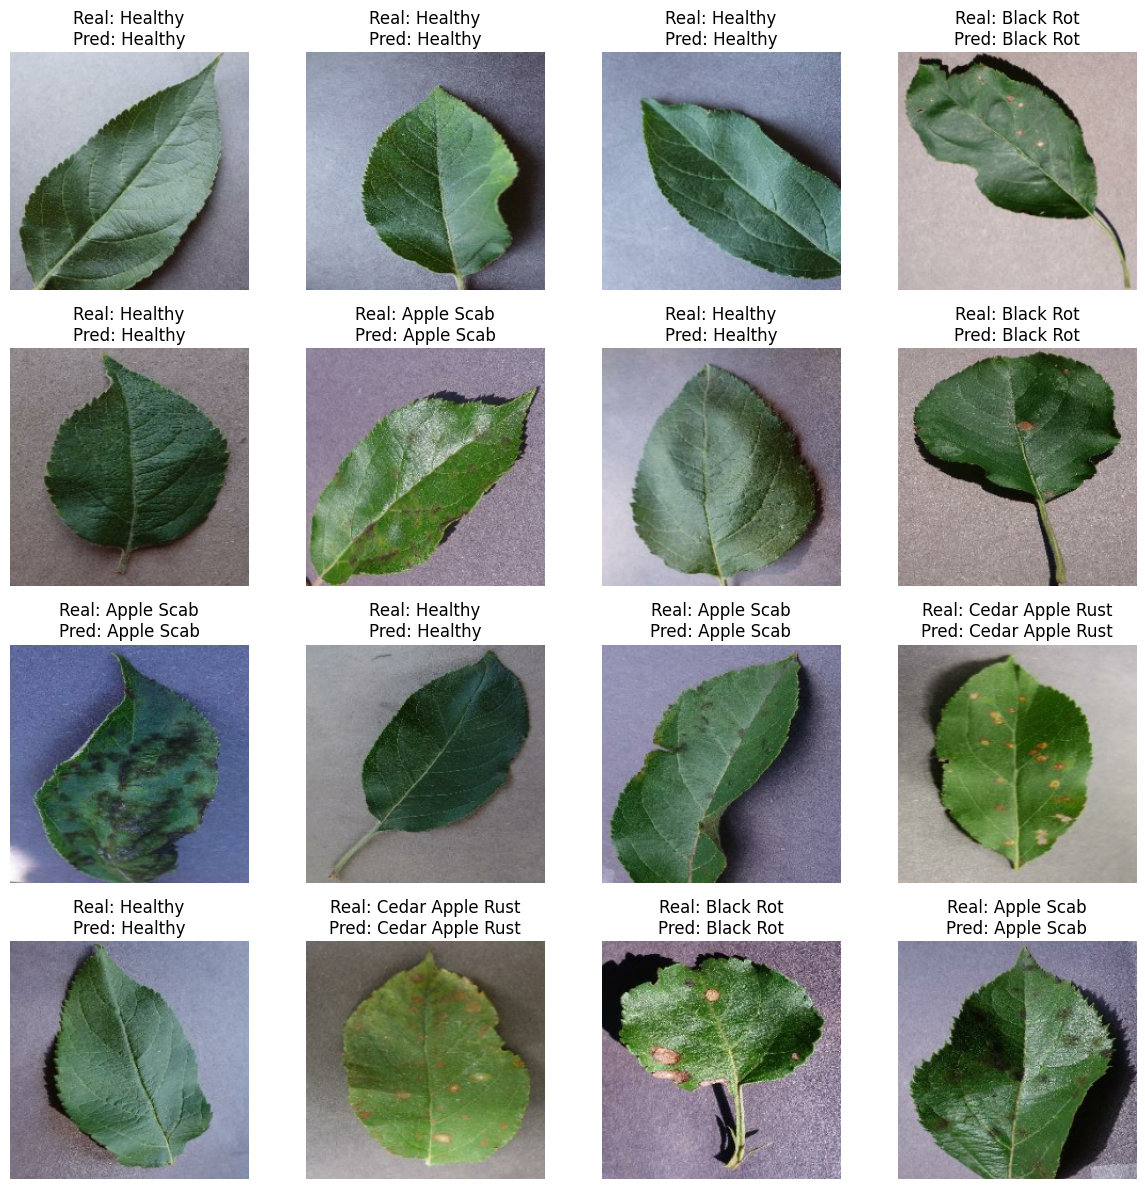

In [114]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, class_names, num_images=16):
    plt.figure(figsize=(12, 12))  
    
    for images, labels in dataset.take(1): 
        predictions = model.predict(images)  
        predicted_classes = np.argmax(predictions, axis=1)  
        true_classes = labels.numpy()  
        
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)  
            plt.imshow(images[i].numpy())
            plt.axis("off")
            
            
            true_label = class_names[true_classes[i]]
            predicted_label = class_names[predicted_classes[i]]
            
            plt.title(f"Real: {true_label}\nPred: {predicted_label}")
    
    plt.tight_layout()
    plt.show()

class_names = ['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy'] 
visualize_predictions(model, test_data, class_names)
